<a href="https://colab.research.google.com/github/RkanGen/Machine-Learning/blob/main/heart_disease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
%matplotlib inline

In [ ]:
# Par exemple, vous pouvez supprimer les lignes avec des valeurs manquantes
#data.dropna(inplace=True)

In [ ]:

df=pd.read_csv('/content/heart.csv')
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [ ]:

df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


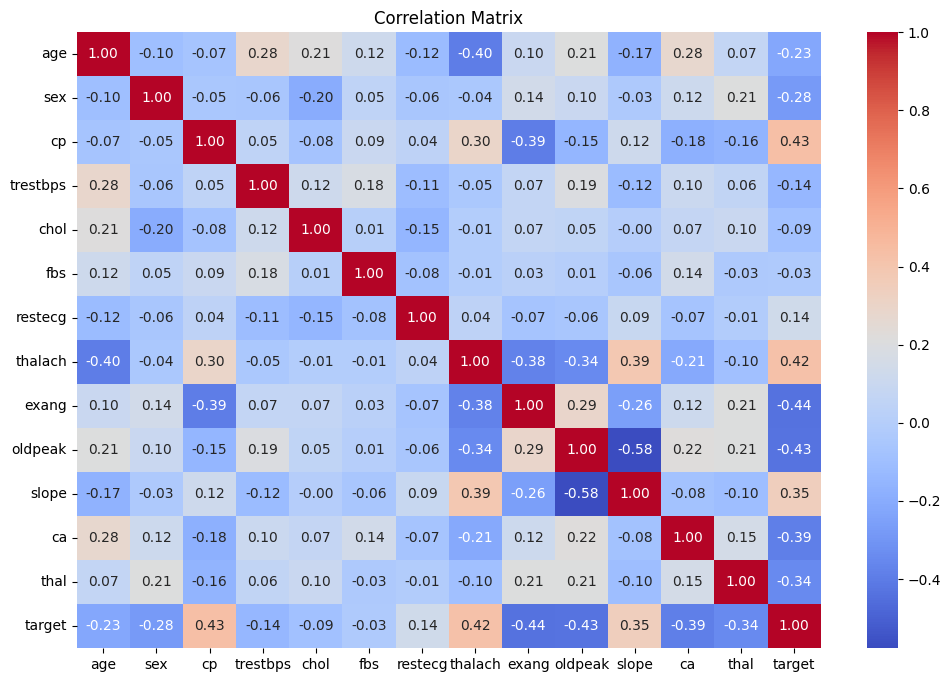

In [ ]:
# Correlation matrix
corr = df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [ ]:
print(df.describe())


              age         sex          cp    trestbps        chol         fbs  \
count  303.000000  303.000000  303.000000  303.000000  303.000000  303.000000   
mean    54.366337    0.683168    0.966997  131.623762  246.264026    0.148515   
std      9.082101    0.466011    1.032052   17.538143   51.830751    0.356198   
min     29.000000    0.000000    0.000000   94.000000  126.000000    0.000000   
25%     47.500000    0.000000    0.000000  120.000000  211.000000    0.000000   
50%     55.000000    1.000000    1.000000  130.000000  240.000000    0.000000   
75%     61.000000    1.000000    2.000000  140.000000  274.500000    0.000000   
max     77.000000    1.000000    3.000000  200.000000  564.000000    1.000000   

          restecg     thalach       exang     oldpeak       slope          ca  \
count  303.000000  303.000000  303.000000  303.000000  303.000000  303.000000   
mean     0.528053  149.646865    0.326733    1.039604    1.399340    0.729373   
std      0.525860   22.9051

In [ ]:
# Define the continuous features
continuous_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

# Identify the features to be converted to object data type
features_to_convert = [feature for feature in df.columns if feature not in continuous_features]

# Convert the identified features to object data type
df[features_to_convert] = df[features_to_convert].astype('object')
df.dtypes

age           int64
sex          object
cp           object
trestbps      int64
chol          int64
fbs          object
restecg      object
thalach       int64
exang        object
oldpeak     float64
slope        object
ca           object
thal         object
target       object
dtype: object

In [ ]:
#df_contiunous=df[continuous_features]

In [ ]:
# Filter out categorical features for the univariate analysis
categorical_features = df.columns.difference(continuous_features)
df_categorical = df[categorical_features]

In [ ]:
# Remove 'target' from the categorical_features
categorical_features = [feature for feature in categorical_features if feature != 'target']


In [ ]:
continuous_features

['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

In [ ]:
# Calculate Q1, Q3, and IQR for continuous features in your DataFrame df
Q1 = df[continuous_features].quantile(0.25)
Q3 = df[continuous_features].quantile(0.75)
IQR = Q3 - Q1

# Count the number of outliers in df using the IQR method
outliers_count_initial = ((df[continuous_features] < (Q1 - 1.5 * IQR)) | (df[continuous_features] > (Q3 + 1.5 * IQR))).sum()

# Get the indices of outliers
outlier_indices = np.where((df[continuous_features] > Q3 +1.5 *IQR) | (df[continuous_features] < Q1- 1.5 *Q1))
# Flatten the array of indices
outlier_indices = np.array(outlier_indices).flatten()

# Drop outliers from df to create df_cleaned
df_cleaned = df.drop(outlier_indices)

# Display information about df_cleaned
print(df_cleaned.info())

# Recalculate Q1, Q3, and IQR based on df_cleaned
Q1_cleaned = df_cleaned[continuous_features].quantile(0.25)
Q3_cleaned = df_cleaned[continuous_features].quantile(0.75)
IQR_cleaned = Q3_cleaned - Q1_cleaned

# Count the number of outliers in df_cleaned
outliers_count_specified = ((df_cleaned[continuous_features] < (Q1_cleaned - 1.5 * IQR_cleaned)) | (df_cleaned[continuous_features] > (Q3_cleaned + 1.5 * IQR_cleaned))).sum()
outliers_count_initial, outliers_count_specified


<class 'pandas.core.frame.DataFrame'>
Index: 282 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       282 non-null    int64  
 1   sex       282 non-null    object 
 2   cp        282 non-null    object 
 3   trestbps  282 non-null    int64  
 4   chol      282 non-null    int64  
 5   fbs       282 non-null    object 
 6   restecg   282 non-null    object 
 7   thalach   282 non-null    int64  
 8   exang     282 non-null    object 
 9   oldpeak   282 non-null    float64
 10  slope     282 non-null    object 
 11  ca        282 non-null    object 
 12  thal      282 non-null    object 
 13  target    282 non-null    object 
dtypes: float64(1), int64(4), object(9)
memory usage: 33.0+ KB
None


(age         0
 trestbps    9
 chol        5
 thalach     1
 oldpeak     5
 dtype: int64,
 age         0
 trestbps    0
 chol        1
 thalach     1
 oldpeak     0
 dtype: int64)

In [ ]:
#from sklearn.preprocessing import OneHotEncoder
#encoder = OneHotEncoder(sparse=False)  # Set sparse=False for easier data manipulation

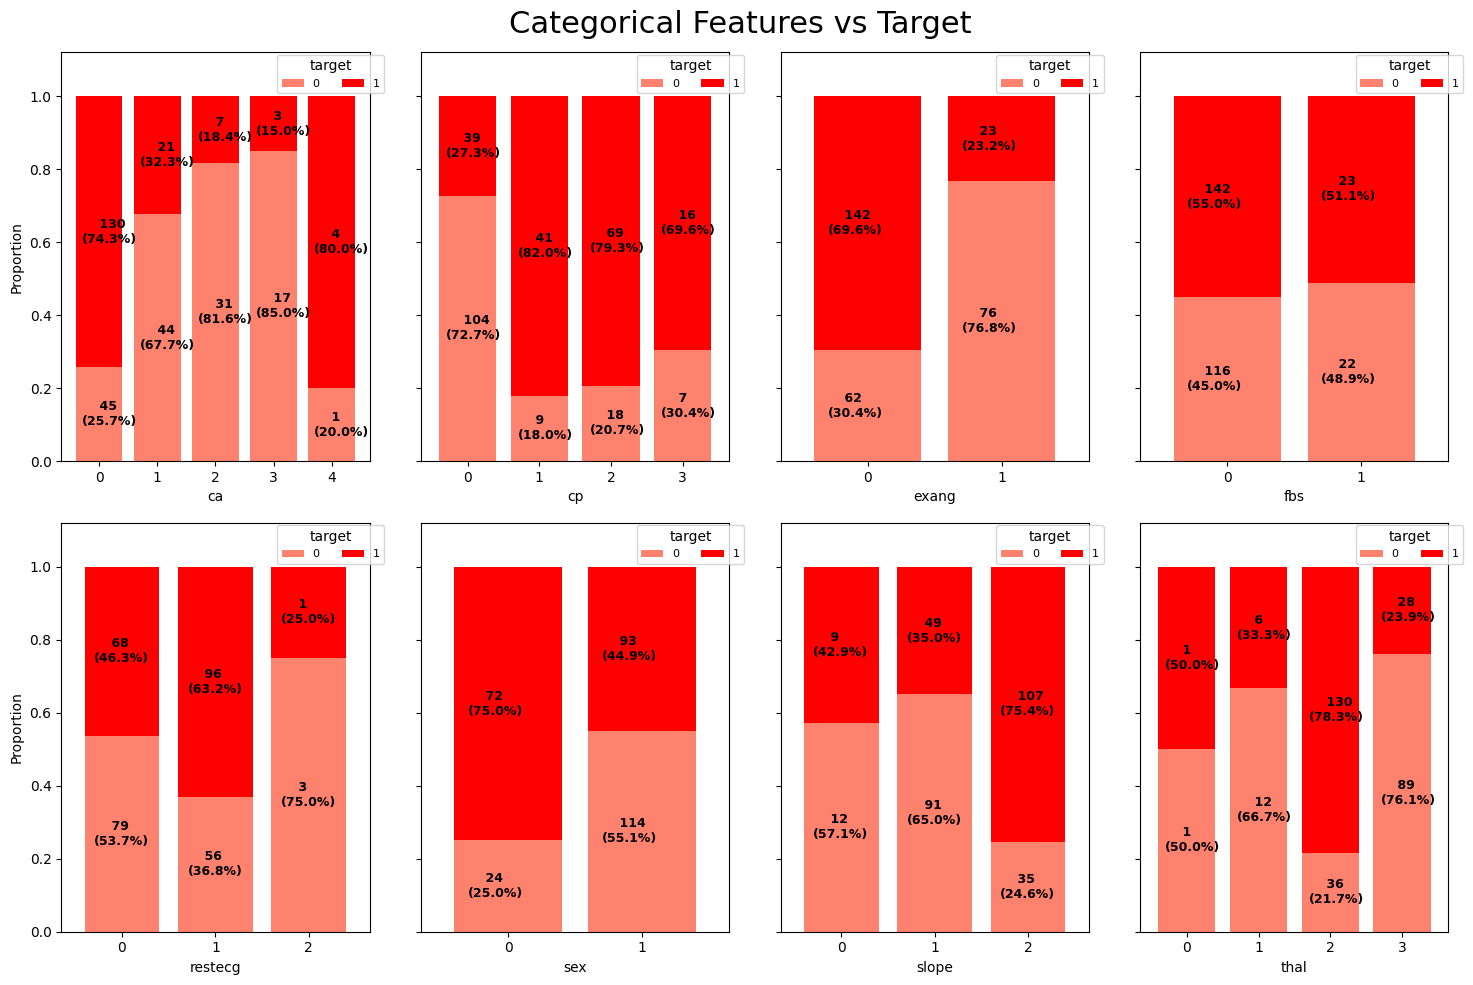

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(15,10))

for i,col in enumerate(categorical_features):

    # Create a cross tabulation showing the proportion of purchased and non-purchased loans for each category of the feature
    cross_tab = pd.crosstab(index=df[col], columns=df['target'])

    # Using the normalize=True argument gives us the index-wise proportion of the data
    cross_tab_prop = pd.crosstab(index=df[col], columns=df['target'], normalize='index')
    # Define colormap
    cmp = ListedColormap(['#ff826e', 'red'])

    # Plot stacked bar charts
    x, y = i//4, i%4
    cross_tab_prop.plot(kind='bar', ax=ax[x,y], stacked=True, width=0.8, colormap=cmp,
                        legend=False, ylabel='Proportion', sharey=True)
    # Add the proportions and counts of the individual bars to our plot
    for idx, val in enumerate([*cross_tab.index.values]):
        for (proportion, count, y_location) in zip(cross_tab_prop.loc[val],cross_tab.loc[val],cross_tab_prop.loc[val].cumsum()):
            ax[x,y].text(x=idx-0.3, y=(y_location-proportion)+(proportion/2)-0.03,
                         s = f'    {count}\n({np.round(proportion * 100, 1)}%)',
                         color = "black", fontsize=9, fontweight="bold")

    # Add legend
    ax[x,y].legend(title='target', loc=(0.7,0.9), fontsize=8, ncol=2)
    # Set y limit
    ax[x,y].set_ylim([0,1.12])
    # Rotate xticks
    ax[x,y].set_xticklabels(ax[x,y].get_xticklabels(), rotation=0)
    plt.suptitle('Categorical Features vs Target ', fontsize=22)
plt.tight_layout()
plt.show()

In [ ]:
# Implementing one-hot encoding on the specified categorical features
#df_encoded=encoder(df, columns=['cp', 'restecg', 'thal'], drop_first=True)
df_encoded = pd.get_dummies(df, columns=['cp', 'restecg', 'thal'], drop_first=True)
df_encoded
# Convert the rest of the categorical variables that don't need one-hot encoding to integer data type
features_to_convert = ['sex', 'fbs', 'exang', 'slope', 'ca', 'target']
for feature in features_to_convert:
  df_encoded[feature] = df_encoded[feature].astype(int)

df_encoded.dtypes

age            int64
sex            int64
trestbps       int64
chol           int64
fbs            int64
thalach        int64
exang          int64
oldpeak      float64
slope          int64
ca             int64
target         int64
cp_1            bool
cp_2            bool
cp_3            bool
restecg_1       bool
restecg_2       bool
thal_1          bool
thal_2          bool
thal_3          bool
dtype: object

In [ ]:
# Displaying the resulting DataFrame after one-hot encoding
df_encoded.head()

,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,slope,ca,target,cp_1,cp_2,cp_3,restecg_1,restecg_2,thal_1,thal_2,thal_3
0,63,1,145,233,1,150,0,2.3,0,0,1,False,False,True,False,False,True,False,False
1,37,1,130,250,0,187,0,3.5,0,0,1,False,True,False,True,False,False,True,False
2,41,0,130,204,0,172,0,1.4,2,0,1,True,False,False,False,False,False,True,False
3,56,1,120,236,0,178,0,0.8,2,0,1,True,False,False,True,False,False,True,False
4,57,0,120,354,0,163,1,0.6,2,0,1,False,False,False,True,False,False,True,False


**Feature** **Scaling**


**Transforming** **Skewed** **Feature**

In [ ]:
# Define the features (X) and the output labels (y)
X = df_encoded.drop('target', axis=1)
y = df_encoded['target']

In [ ]:
# Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
continuous_features

['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

In [ ]:
import warnings
warnings.filterwarnings('ignore')
# transform data to numeric to enable further analysis
#df = df.apply(pd.to_numeric)
#df.dtypes

In [ ]:
X_train.head()

,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,slope,ca,cp_1,cp_2,cp_3,restecg_1,restecg_2,thal_1,thal_2,thal_3
19,69,0,140,239,0,151,0,1.8,2,2,False,False,True,True,False,False,True,False
247,66,1,160,246,0,120,1,0.0,1,3,True,False,False,True,False,True,False,False
289,55,0,128,205,0,130,1,2.0,1,1,False,False,False,False,True,False,False,True
288,57,1,110,335,0,143,1,3.0,1,1,False,False,False,True,False,False,False,True
60,71,0,110,265,1,130,0,0.0,2,1,False,True,False,False,False,False,True,False


# **Decision Tree Model Building**


In [ ]:
# Define the base DT model
dt_base = DecisionTreeClassifier(random_state=0)

In [ ]:
def tune_clf_hyperparameters(clf, param_grid, X_train, y_train, scoring='accuracy', n_splits=3):
  # Create the cross-validation object using StratifiedKFold to ensure the class distribution is the same across all the folds
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)

    # Create the GridSearchCV object
    clf_grid = GridSearchCV(clf, param_grid, cv=cv, scoring=scoring, n_jobs=-1)

    # Fit the GridSearchCV object to the training data
    clf_grid.fit(X_train, y_train)

    # Get the best hyperparameters
    best_hyperparameters = clf_grid.best_params_

    # Return best_estimator_ attribute which gives us the best model that has been fitted to the training data
    return clf_grid.best_estimator_, best_hyperparameters

In [ ]:
# Hyperparameter grid for DT
param_grid_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [2,3],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2]
}

In [ ]:
# Call the function for hyperparameter tuning
best_dt, best_dt_hyperparams = tune_clf_hyperparameters(dt_base, param_grid_dt, X_train, y_train)

In [ ]:
print('DT Optimal Hyperparameters: \n', best_dt_hyperparams)

DT Optimal Hyperparameters: 
 {'criterion': 'entropy', 'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2}


# **Decision Tree Model Evaluation**

In [ ]:
# Evaluate the optimized model on the train data
print(classification_report(y_train, best_dt.predict(X_train)))

              precision    recall  f1-score   support

           0       0.89      0.60      0.72       110
           1       0.74      0.94      0.83       132

    accuracy                           0.79       242
   macro avg       0.81      0.77      0.77       242
weighted avg       0.81      0.79      0.78       242



In [ ]:
# Evaluate the optimized model on the test data
print(classification_report(y_test, best_dt.predict(X_test)))

              precision    recall  f1-score   support

           0       0.73      0.29      0.41        28
           1       0.60      0.91      0.72        33

    accuracy                           0.62        61
   macro avg       0.66      0.60      0.57        61
weighted avg       0.66      0.62      0.58        61



In [ ]:
from sklearn.metrics import classification_report, accuracy_score
def evaluate_model(model, X_test, y_test, model_name):
  y_pred = model.predict(X_test)
  report = classification_report(y_test, y_pred, output_dict=True)
  metrics = {"accuracy": accuracy_score(y_test, y_pred),"precision_0": report["0"]["precision"],
        "precision_1": report["1"]["precision"],
        "recall_0": report["0"]["recall"],
        "recall_1": report["1"]["recall"],
        "f1_0": report["0"]["f1-score"],
        "f1_1": report["1"]["f1-score"]}
  df = pd.DataFrame(metrics, index=[model_name]).round(2)
  return df

In [ ]:
dt_evaluation = evaluate_model(best_dt, X_test, y_test, 'DT')
dt_evaluation

,accuracy,precision_0,precision_1,recall_0,recall_1,f1_0,f1_1
DT,0.62,0.73,0.6,0.29,0.91,0.41,0.72


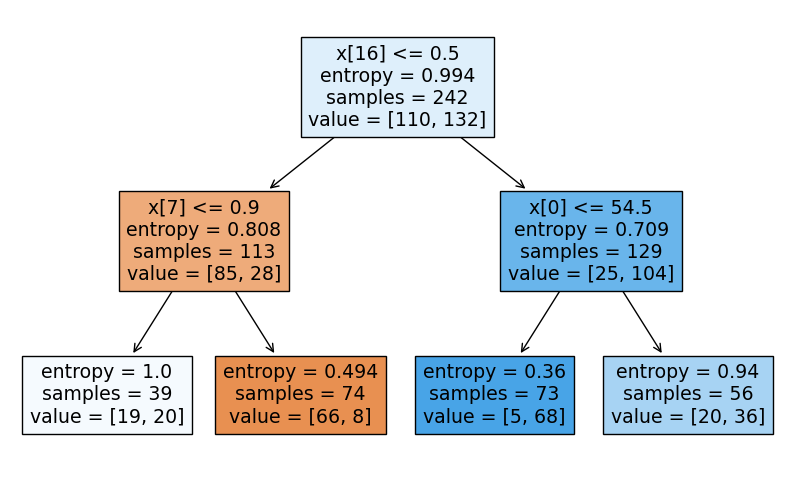

In [ ]:
from sklearn import tree
rf_model = RandomForestClassifier(n_estimators=10)
tree_to_visualize = best_dt

# Visualisez l'arbre
plt.figure(figsize=(10, 6))
tree.plot_tree(tree_to_visualize, filled=True)
plt.show()

# **Random Forest Model Building**

In [ ]:
# Evaluate the optimized model on the train data
#print(classification_report(y_train, best_rf.predict(X_train)))
rf_base = RandomForestClassifier(random_state=0)

In [ ]:
param_grid_rf = {
    'n_estimators': [90,100,130],
    'criterion': ['gini', 'entropy'],
    'max_depth': [5,6,7],
    'min_samples_split': [2, 3],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}

In [ ]:
# Using the tune_clf_hyperparameters function to get the best estimator
best_rf, best_rf_hyperparams = tune_clf_hyperparameters(rf_base, param_grid_rf, X_train, y_train)
print('RF Optimal Hyperparameters: \n', best_rf_hyperparams)

RF Optimal Hyperparameters: 
 {'bootstrap': True, 'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 130}


In [ ]:
# Evaluate the optimized model on the train data
print(classification_report(y_train, best_rf.predict(X_train)))
# Evaluate the optimized model on the test data
print(classification_report(y_test, best_rf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.97      0.92      0.94       110
           1       0.93      0.98      0.96       132

    accuracy                           0.95       242
   macro avg       0.95      0.95      0.95       242
weighted avg       0.95      0.95      0.95       242

              precision    recall  f1-score   support

           0       0.83      0.68      0.75        28
           1       0.76      0.88      0.82        33

    accuracy                           0.79        61
   macro avg       0.79      0.78      0.78        61
weighted avg       0.79      0.79      0.78        61



In [ ]:
rf_evaluation = evaluate_model(best_rf, X_test, y_test, 'RF')
rf_evaluation

,accuracy,precision_0,precision_1,recall_0,recall_1,f1_0,f1_1
RF,0.79,0.83,0.76,0.68,0.88,0.75,0.82


In [ ]:
# Evaluate the optimized model on the test data
#print(classification_report(y_test, best_rf.predict(X_test)))

In [ ]:
#rf_evaluation = evaluate_model(best_rf, X_test, y_test, 'RF')
#rf_evaluation

# **KNN Model Building**

In [ ]:
# Define the base KNN model and set up the pipeline with scaling
knn_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

In [ ]:
#KNN Hyperparameter Tuning
# Hyperparameter grid for KNN
knn_param_grid = {
    'knn__n_neighbors': list(range(1, 15)),
    'knn__weights': ['uniform', 'distance'],
    'knn__p': [1, 2]  # 1: Manhattan distance, 2: Euclidean distance
}

In [ ]:
# Hyperparameter tuning for KNN
best_knn, best_knn_hyperparams = tune_clf_hyperparameters(knn_pipeline, knn_param_grid, X_train, y_train)
print('KNN Optimal Hyperparameters: \n', best_knn_hyperparams)

KNN Optimal Hyperparameters: 
 {'knn__n_neighbors': 13, 'knn__p': 2, 'knn__weights': 'distance'}


# **KNN Model Evaluation**

In [ ]:
# Evaluate the optimized model on the train data
print(classification_report(y_train, best_knn.predict(X_train)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       110
           1       1.00      1.00      1.00       132

    accuracy                           1.00       242
   macro avg       1.00      1.00      1.00       242
weighted avg       1.00      1.00      1.00       242



In [ ]:
# Evaluate the optimized model on the test data
print(classification_report(y_test, best_knn.predict(X_test)))

              precision    recall  f1-score   support

           0       0.88      0.75      0.81        28
           1       0.81      0.91      0.86        33

    accuracy                           0.84        61
   macro avg       0.84      0.83      0.83        61
weighted avg       0.84      0.84      0.83        61



In [ ]:
knn_evaluation = evaluate_model(best_knn, X_test, y_test, 'KNN')
knn_evaluation

,accuracy,precision_0,precision_1,recall_0,recall_1,f1_0,f1_1
KNN,0.84,0.88,0.81,0.75,0.91,0.81,0.86


In [ ]:
from sklearn.ensemble import AdaBoostClassifier
# Initialize AdaBoost classifier with decision tree as base estimator
ada_clf = AdaBoostClassifier(n_estimators=50, random_state=42)
# Train the AdaBoost classifier
ada_clf.fit(X_train, y_train)

# Predict on the testing set
y_pred = ada_clf.predict(X_test)

In [ ]:
# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Print classification report and confusion matrix
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.7868852459016393

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.75      0.76        28
           1       0.79      0.82      0.81        33

    accuracy                           0.79        61
   macro avg       0.79      0.78      0.78        61
weighted avg       0.79      0.79      0.79        61



In [ ]:
ab_evaluation=evaluate_model(ada_clf, X_test, y_test, 'AB')
ab_evaluation

,accuracy,precision_0,precision_1,recall_0,recall_1,f1_0,f1_1
AB,0.79,0.78,0.79,0.75,0.82,0.76,0.81


# **SVM Model Building**

In [ ]:
svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(probability=True))
])

In [ ]:
#SVM Hyperparameter Tuning
param_grid_svm = {
    'svm__C': [ 0.01, 0.05, 0.1, 1],
    'svm__kernel': ['linear', 'rbf', 'poly'],
    'svm__gamma': ['scale', 'auto', 0.1, 0.5, 1],
    'svm__degree': [1,2, 3, 4]
}

In [ ]:
# Call the function for hyperparameter tuning
best_svm, best_svm_hyperparams = tune_clf_hyperparameters(svm_pipeline, param_grid_svm, X_train, y_train)
print('SVM Optimal Hyperparameters: \n', best_svm_hyperparams)


SVM Optimal Hyperparameters: 
 {'svm__C': 0.01, 'svm__degree': 1, 'svm__gamma': 'scale', 'svm__kernel': 'linear'}


In [ ]:
#SVM Model Evaluation
# Evaluate the optimized model on the train data
print(classification_report(y_train, best_svm.predict(X_train)))
# Evaluate the optimized model on the test data
print(classification_report(y_test, best_svm.predict(X_test)))

              precision    recall  f1-score   support

           0       0.86      0.85      0.86       110
           1       0.88      0.89      0.88       132

    accuracy                           0.87       242
   macro avg       0.87      0.87      0.87       242
weighted avg       0.87      0.87      0.87       242

              precision    recall  f1-score   support

           0       0.87      0.71      0.78        28
           1       0.79      0.91      0.85        33

    accuracy                           0.82        61
   macro avg       0.83      0.81      0.81        61
weighted avg       0.83      0.82      0.82        61



In [ ]:
svm_evaluation = evaluate_model(best_svm, X_test, y_test, 'SVM')
svm_evaluation

,accuracy,precision_0,precision_1,recall_0,recall_1,f1_0,f1_1
SVM,0.82,0.87,0.79,0.71,0.91,0.78,0.85


In [ ]:
# Concatenate the dataframes
all_evaluations = [dt_evaluation, rf_evaluation, knn_evaluation, svm_evaluation,ab_evaluation]
results = pd.concat(all_evaluations)

# Sort by 'accuracy'
results = results.sort_values(by='accuracy', ascending=False).round(3)
results

,accuracy,precision_0,precision_1,recall_0,recall_1,f1_0,f1_1
KNN,0.84,0.88,0.81,0.75,0.91,0.81,0.86
SVM,0.82,0.87,0.79,0.71,0.91,0.78,0.85
RF,0.79,0.83,0.76,0.68,0.88,0.75,0.82
AB,0.79,0.78,0.79,0.75,0.82,0.76,0.81
DT,0.62,0.73,0.60,0.29,0.91,0.41,0.72


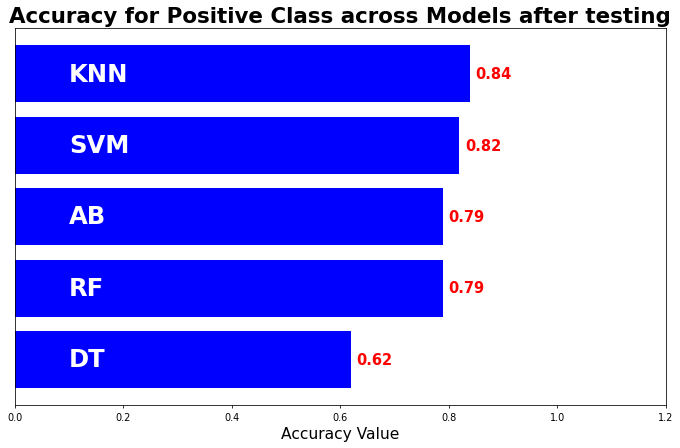

In [ ]:
# Sort values based on 'recall_1'
results.sort_values(by='accuracy', ascending=True, inplace=True)
accuracy_scores = results['accuracy']

# Plot the horizontal bar chart
fig, ax = plt.subplots(figsize=(12, 7), dpi=70)
ax.barh(results.index, accuracy_scores , color='blue')

# Annotate the values and indexes
for i, (value, name) in enumerate(zip(accuracy_scores, results.index)):
    ax.text(value + 0.01, i, f"{value:.2f}", ha='left', va='center', fontweight='bold', color='red', fontsize=15)
    ax.text(0.1, i, name, ha='left', va='center', fontweight='bold', color='white', fontsize=25)
# Remove yticks
ax.set_yticks([])

# Set x-axis limit
ax.set_xlim([0, 1.2])

# Add title and xlabel
plt.title("Accuracy for Positive Class across Models after testing", fontweight='bold', fontsize=22)
plt.xlabel('Accuracy Value', fontsize=16)
plt.show()

# **Artificial Neural Network**

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [ ]:
# Define the model
model = Sequential()
model.add(Dense(1, input_dim=X_train.shape[1], activation='relu')) # Input layer
model.add(Dense(8, activation='relu')) # Hidden layer
model.add(Dense(1, activation='sigmoid')) # Output layer

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [ ]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
X_train1 = tf.convert_to_tensor(X_train_scaled, dtype=tf.float32)
y_train1 = tf.convert_to_tensor(y_train, dtype=tf.float32)
X_test1=tf.convert_to_tensor(X_test_scaled, dtype=tf.float32)
y_test1=tf.convert_to_tensor(y_test, dtype=tf.float32)

In [ ]:
def create_binary_model():
    # create model
    model = Sequential()
    model.add(Dense(1, input_dim=13, kernel_initializer='normal', activation='relu'))
    model.add(Dense(8, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

binary_model = create_binary_model()

print(binary_model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 1)                 14        
                                                                 
 dense_4 (Dense)             (None, 8)                 16        
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 39 (156.00 Byte)
Trainable params: 39 (156.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

Epoch 1/30
25/25 [==============================] - 1s 11ms/step - loss: 0.6974 - accuracy: 0.5455 - val_loss: 0.7023 - val_accuracy: 0.5574
Epoch 2/30
25/25 [==============================] - 0s 3ms/step - loss: 0.6918 - accuracy: 0.5950 - val_loss: 0.6989 - val_accuracy: 0.5574
Epoch 3/30
25/25 [==============================] - 0s 4ms/step - loss: 0.6874 - accuracy: 0.5992 - val_loss: 0.6953 - val_accuracy: 0.5902
Epoch 4/30
25/25 [==============================] - 0s 4ms/step - loss: 0.6835 - accuracy: 0.6157 - val_loss: 0.6924 - val_accuracy: 0.6066
Epoch 5/30
25/25 [==============================] - 0s 4ms/step - loss: 0.6789 - accuracy: 0.6322 - val_loss: 0.6884 - val_accuracy: 0.6066
Epoch 6/30
25/25 [==============================] - 0s 3ms/step - loss: 0.6737 - accuracy: 0.6612 - val_loss: 0.6841 - val_accuracy: 0.6230
Epoch 7/30
25/25 [==============================] - 0s 3ms/step - loss: 0.6681 - accuracy: 0.6818 - val_loss: 0.6800 - val_accuracy: 0.6230
Epoch 8/30
25/25 [=

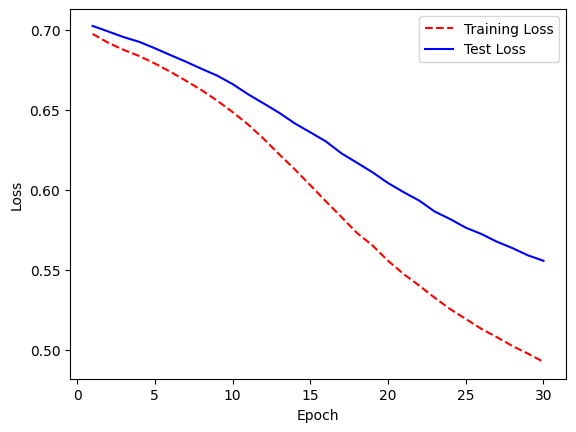

In [ ]:
# Train the model
net=model.fit(X_train1, y_train1, epochs=30, batch_size=10,validation_data=(X_test1, y_test1))
# Get training and test loss histories
training_loss = net.history["loss"]
test_loss = net.history["val_loss"]
# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)
# Visualize loss history
plt.plot(epoch_count, training_loss, "r--")
plt.plot(epoch_count, test_loss, "b-")
plt.legend(["Training Loss", "Test Loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show();



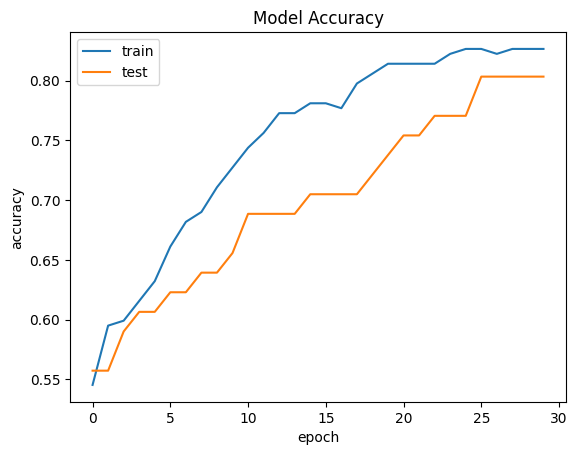

In [ ]:
plt.plot(net.history['accuracy'])
plt.plot(net.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

In [ ]:
# Make predictions
y_pred = model.predict(X_test1)
y_pred=(y_pred > 0.5).astype(int)
#y_pred =net.predict(X_test1)
# Evaluate the model
print("Accuracy:", accuracy_score(y_test1, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test1, y_pred))
print("\nClassification Report:\n", classification_report(y_test1, y_pred))


2/2 [==============================] - 0s 5ms/step
Accuracy: 0.8032786885245902

Confusion Matrix:
 [[21  7]
 [ 5 28]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.81      0.75      0.78        28
         1.0       0.80      0.85      0.82        33

    accuracy                           0.80        61
   macro avg       0.80      0.80      0.80        61
weighted avg       0.80      0.80      0.80        61



In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

# Assuming y_true contains the true labels and y_pred contains the predicted probabilities
fpr, tpr, thresholds = roc_curve(y_test1, y_pred)
auc_score = roc_auc_score(y_test1, y_pred)

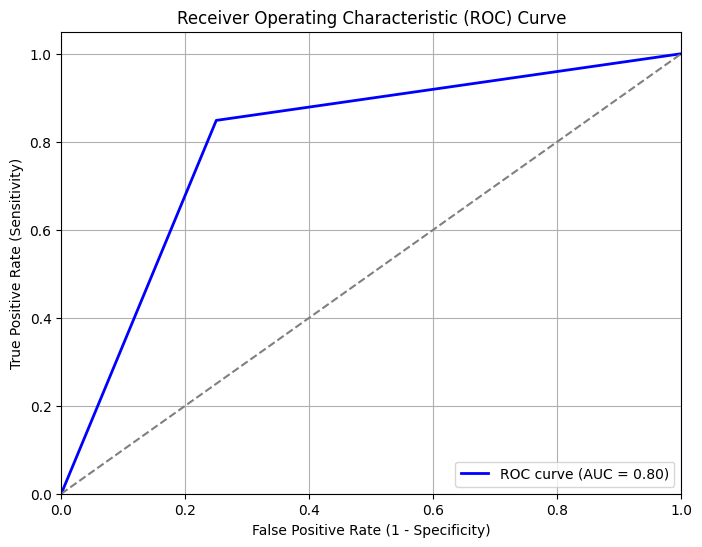

In [ ]:


# Assuming y_true contains the true labels and y_pred contains the predicted probabilities
fpr, tpr, thresholds = roc_curve(y_test1, y_pred)
auc_score = roc_auc_score(y_test1, y_pred)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = {:.2f})'.format(auc_score))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


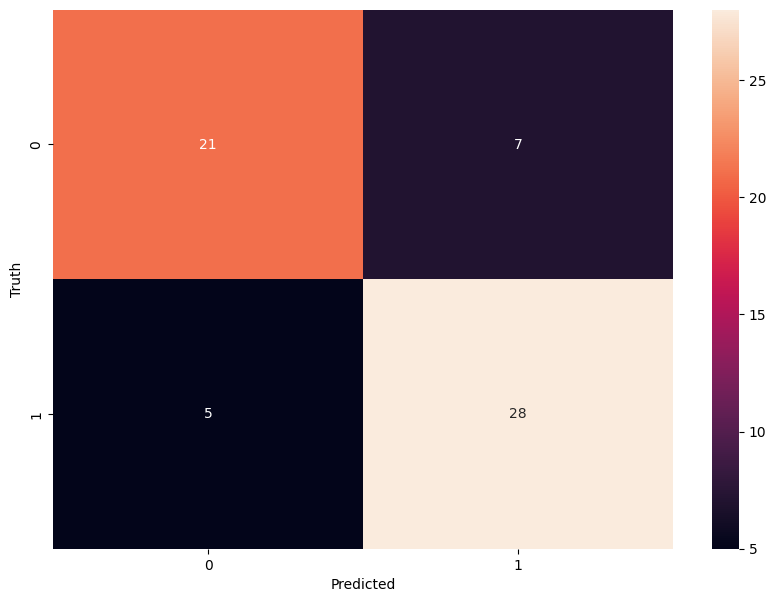

In [ ]:
# Visualize the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score


In [ ]:
precision = precision_score(y_test1, y_pred)
recall = recall_score(y_test1, y_pred)
f1 = f1_score(y_test1, y_pred)

print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)


Precision: 0.8
Recall: 0.8484848484848485
F1-Score: 0.823529411764706


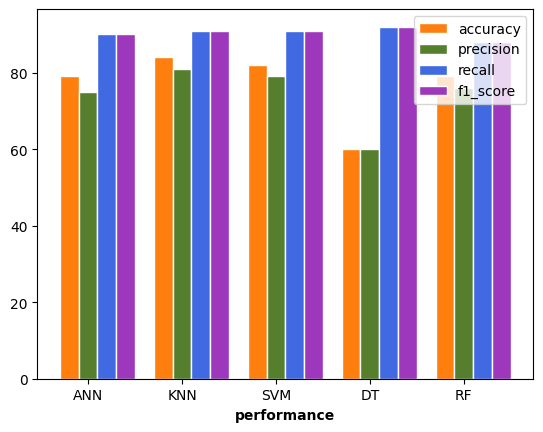

In [ ]:
barWidth = 0.2

# set heights of bars
bars1 = [79,84,82,60,79]
bars2 = [75,81,79,60,76]
bars3 = [90,91,91,92,88]
bars4 = [82,86,85,72,82]
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
# Make the plot
plt.bar(r1, bars1, color='#FF7F0E', width=barWidth, edgecolor='white', label='accuracy')
plt.bar(r2, bars2, color='#557f2d', width=barWidth, edgecolor='white', label='precision')
plt.bar(r3, bars3, color='#4169E1', width=barWidth, edgecolor='white', label='recall')
plt.bar(r4, bars3, color='#9D38BD', width=barWidth, edgecolor='white', label='f1_score')
# Add xticks on the middle of the group bars
plt.xlabel('performance', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], ['ANN', 'KNN', 'SVM', 'DT','RF'])

# Create legend & Show graphic
plt.legend()
plt.show()